In [1]:
# libraries

import seaborn as sns
import xarray as xr
import numpy as np
import pandas as pd
import intake
import fsspec
import dask
import warnings
from tqdm import tqdm
from xmip.preprocessing import combined_preprocessing
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# data

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
    col = intake.open_esm_datastore(url)

In [ ]:
# set up the local filecache path for faster reading (~5 min w 50 cores and 50 GB memory)

cache_path = '/scratch/fld1/cmip_cache'

storage_options = {
    'filecache': {
        'cache_storage': cache_path,
        'target_protocol': 'gs',
    }
}

# load 6-hourly data with meridional and zonal wind, air temperature, surface pressure, and specific humidity

query = dict(source_id='MRI-ESM2-0',
             table_id='6hrLev',
             experiment_id=['historical', 'ssp585'],
             variable_id=['va', 'ua', 'ta']
)

cat = col.search(**query)

# load data into dictionary use print(dset_dict.keys()) for keys

warnings.filterwarnings("ignore")

z_kwargs = {'consolidated': True, 'decode_times':True}

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dset_dict = cat.to_dataset_dict(
        zarr_kwargs=z_kwargs,
        #storage_options=storage_options,
        preprocessing=combined_preprocessing
)

print(dset_dict.keys())

(1.0, 0.4)

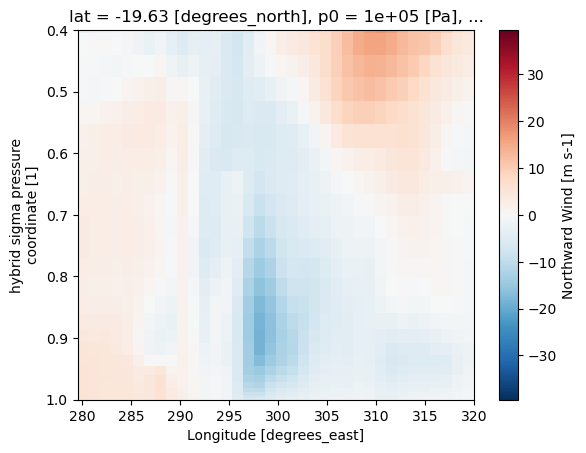

In [ ]:
# select one year of 6-hourly ssp585 data for testing (with 50 cores and 50 GB memory)

ds = dset_dict['ScenarioMIP.MRI.MRI-ESM2-0.ssp585.6hrLev.gn'].sel(time=slice('2060', '2060'))
ds

# may want to ammend this to also just select SA so we arent doing calculations on
# areas we are not going to use in analysis

ax = ds.va.sel(lon=slice(280, 320)).sel(lat=-20, method = 'nearest').isel(time=225).plot()
ax.axes.set_ylim(1, 0.4)

In [ ]:
# assign total wind vector field

subset = (ds
    # select just south america
    .sel(lon=slice(270, 330), lat=slice(-40, 10))
    # calculate wind speed on pressure levels
    .assign(pWind=lambda x: np.sqrt(x['ua']**2 + x['va']**2))
    # get meridional and zonal wind on LLJ pressure level (0.8)
    .assign(uas=lambda x: x['ua'].sel(lev=0.8, method='nearest'))
    .assign(vas=lambda x: x['va'].sel(lev=0.8, method='nearest'))
    .squeeze()
    .compute())

subset

<xarray.Dataset> Size: 5GB
Dimensions:         (lev: 80, bnds: 2, lat: 45, lon: 54, time: 1464)
Coordinates: (12/15)
    a               (lev) float64 640B 0.0 0.0 0.0 ... 5.232e-05 2.848e-05 1e-05
    a_bnds          (lev, bnds) float64 1kB 0.0 0.0 0.0 0.0 ... 2e-05 2e-05 0.0
    b               (lev) float64 640B 0.9985 0.9955 0.9915 ... 0.0 0.0 0.0
    b_bnds          (lev, bnds) float64 1kB 1.0 0.997 0.997 ... 0.0 0.0 0.0
  * lat             (lat) float64 360B -39.81 -38.69 -37.57 ... 7.29 8.411 9.533
    lat_bnds        (lat, bnds) float64 720B -40.37 -39.25 ... 8.972 10.09
    ...              ...
    lon_bnds        (lon, bnds) float64 864B 269.4 270.6 270.6 ... 329.1 330.2
    p0              float64 8B 1e+05
    ps              (time, lat, lon) float32 14MB 1.027e+05 ... 1.011e+05
  * time            (time) datetime64[ns] 12kB 2060-01-01 ... 2060-12-31T18:0...
    member_id       <U8 32B 'r1i1p1f1'
    dcpp_init_year  float64 8B nan
Dimensions without coordinates: bnds
Data variables:
    va              (time, lev, lat, lon) float32 1GB -3.497 -2.301 ... 37.53
    ta              (time, lev, lat, lon) float32 1GB 290.9 290.6 ... 198.1
    ua              (time, lev, lat, lon) float32 1GB 4.897 4.741 ... -0.2159
    pWind           (time, lev, lat, lon) float32 1GB 6.017 5.27 ... 38.83 37.53
    uas             (time, lat, lon) float32 14MB 8.049 8.065 ... -3.76 -4.031
    vas             (time, lat, lon) float32 14MB -2.332 -2.015 ... 2.338 2.407
Attributes: (12/51)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             60265.0
    branch_time_in_parent:            60265.0
    cmor_version:                     3.4.0
    ...                               ...
    intake_esm_attrs:table_id:        6hrLev
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20190625
    intake_esm_attrs:_data_format_:   zarr
    external_variables:               areacella
    intake_esm_dataset_key:           ScenarioMIP.MRI.MRI-ESM2-0.ssp585.6hrLe...

In [ ]:
# quiver plot during LLJ time (time = 225)

dst = subset.isel(time=225).sel(lev=0.8, method='nearest')
dst

<xarray.Dataset> Size: 71kB
Dimensions:         (bnds: 2, lat: 45, lon: 54)
Coordinates: (12/15)
    a               float64 8B 0.02045
    a_bnds          (bnds) float64 16B 0.01791 0.02295
    b               float64 8B 0.7665
    b_bnds          (bnds) float64 16B 0.7851 0.7481
  * lat             (lat) float64 360B -39.81 -38.69 -37.57 ... 7.29 8.411 9.533
    lat_bnds        (lat, bnds) float64 720B -40.37 -39.25 ... 8.972 10.09
    ...              ...
    lon_bnds        (lon, bnds) float64 864B 269.4 270.6 270.6 ... 329.1 330.2
    p0              float64 8B 1e+05
    ps              (lat, lon) float32 10kB 1.027e+05 1.026e+05 ... 1.013e+05
    time            datetime64[ns] 8B 2060-02-26T06:00:00
    member_id       <U8 32B 'r1i1p1f1'
    dcpp_init_year  float64 8B nan
Dimensions without coordinates: bnds
Data variables:
    va              (lat, lon) float32 10kB 3.825 3.896 4.02 ... -0.7981 -0.1623
    ta              (lat, lon) float32 10kB 280.0 279.3 278.8 ... 292.8 292.7
    ua              (lat, lon) float32 10kB 7.674 8.464 9.161 ... 1.421 0.3479
    pWind           (lat, lon) float32 10kB 8.575 9.318 10.0 ... 1.63 0.3839
    uas             (lat, lon) float32 10kB 7.674 8.464 9.161 ... 1.421 0.3479
    vas             (lat, lon) float32 10kB 3.825 3.896 4.02 ... -0.7981 -0.1623
Attributes: (12/51)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             60265.0
    branch_time_in_parent:            60265.0
    cmor_version:                     3.4.0
    ...                               ...
    intake_esm_attrs:table_id:        6hrLev
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20190625
    intake_esm_attrs:_data_format_:   zarr
    external_variables:               areacella
    intake_esm_dataset_key:           ScenarioMIP.MRI.MRI-ESM2-0.ssp585.6hrLe...

Text(0.5, 1.0, 'Surface Wind Vectors with Wind Speed (m/s)')

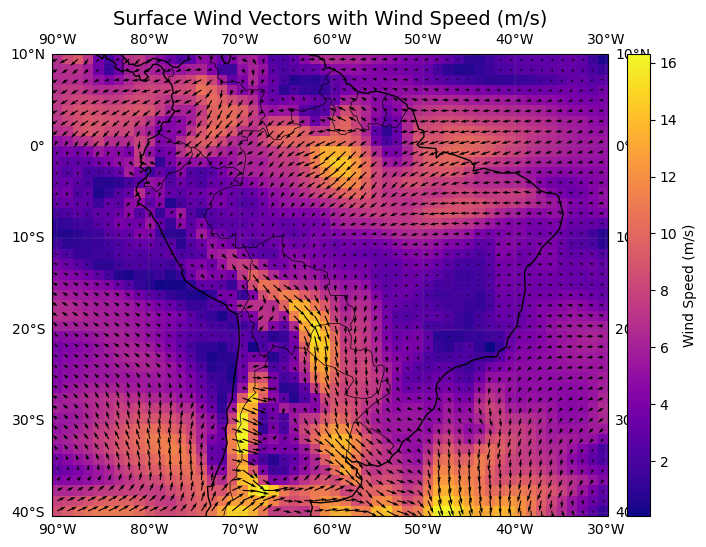

In [ ]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs

# cartopy mapping things
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': proj})

# add background wind speed as color shading
speed_plot = ax.pcolormesh(
    dst.lon, dst.lat, dst.pWind,
    transform=proj, cmap='plasma', shading='auto'
)

# add colorbar
cbar = plt.colorbar(speed_plot, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Wind Speed (m/s)')

# plot wind vectors
q = ax.quiver(
    dst.lon, dst.lat,
    dst.uas, dst.vas,
    transform=proj, scale=500, width=0.002, color='k'
)

# add quiver key
ax.quiverkey(q, 0.9, -0.1, 10, "10 m/s", labelpos='E')

# add Cartopy features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=0)
ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)

# title
ax.set_title('Surface Wind Vectors with Wind Speed (m/s)', fontsize=14)

Text(0.5, 1.0, 'Meridional Wind Profile')

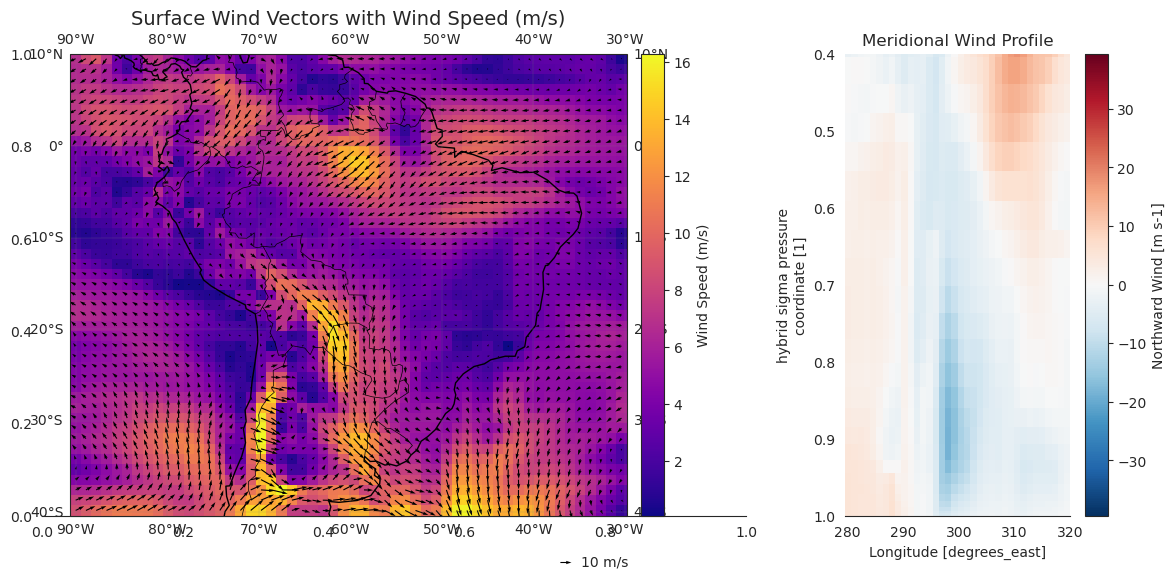

In [ ]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs

# cartopy mapping things
proj = ccrs.PlateCarree()
fig = plt.subplots(figsize=(14, 6), ncols=2, gridspec_kw={"width_ratios": [2.5, 1]})
fig, (ax1, ax2) = fig
sns.set_style('white')
sns.despine(ax=ax2, top=True, bottom=True, right=True, left=True)
sns.despine(ax=ax1, top=True, bottom=True, right=True, left=True)

# plot number one
ax1 = plt.subplot(1, 2, 1, projection=proj)

# add background wind speed as color shading
speed_plot = ax1.pcolormesh(
    dst.lon, dst.lat, dst.pWind,
    transform=proj, cmap='plasma', shading='auto'
)

# add colorbar
cbar = plt.colorbar(speed_plot, ax=ax1, orientation='vertical', pad=0.02)
cbar.set_label('Wind Speed (m/s)')

# plot wind vectors
q = ax1.quiver(
    dst.lon, dst.lat,
    dst.uas, dst.vas,
    transform=proj, scale=500, width=0.002, color='k'
)

# add quiver key
ax1.quiverkey(q, 0.9, -0.1, 10, "10 m/s", labelpos='E')
ax1.set_xlabel('Longitude (degrees east)')
ax1.set_ylabel('Latitude (degrees north)')

# add Cartopy features
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
ax1.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=0)
# ax1.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)

# title
ax1.set_title('Surface Wind Vectors with Wind Speed (m/s)', fontsize=14)

# left panel
ax = subset.sel(lon=slice(280, 320)).sel(lat=-20, method='nearest').isel(time=225).va.plot(ax=ax2)
ax.axes.set_ylim(1, 0.4)
ax.axes.set_title('Meridional Wind Profile')